# Image preprocessing ([#8](https://github.com/molinari135/embryo-project/issues/8))

In this notebook, we perform the following operations:

1. Remove writings from the lower section of every image
2. Make every image squared again
3. Check the dynamic range of every image (for very dark images)
4. Rename images adding _0 or _1 with respect to their label in annotations

In order to perform all these operations it is **required** to run the previous notebook by number convention.

In [1]:
import cv2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from loguru import logger
from embryo_project.config import INTERIM_DATA_DIR, FIGURES_DIR, ANNOTATIONS_FILE

2025-08-05 15:03:19.111 | INFO     | embryo_project.config:<module>:11 - PROJ_ROOT path is: C:\Users\Molinari\Desktop\embryo-project


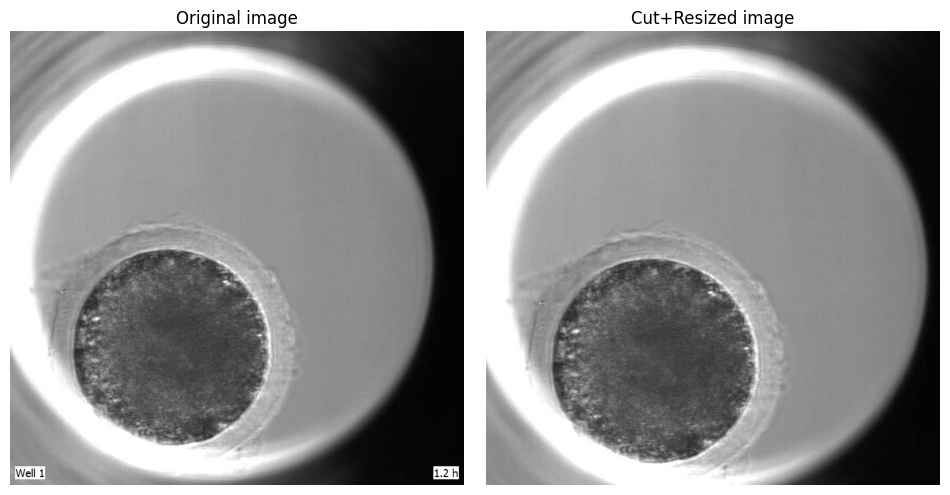

In [2]:
cut_bottom = 33

folders = sorted([f for f in INTERIM_DATA_DIR.iterdir() if f.is_dir()])
first_folder = folders[0]
image_files = sorted(list(first_folder.glob("*.JPG")))

first_image_path = image_files[0]
img = cv2.imread(str(first_image_path))

if img is None:
    logger.error("Error loading image")
else:
    h, w = img.shape[:2]

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_cropped = img[:h - cut_bottom, :, :]
    side = min(img_cropped.shape[:2])
    img_square = img_cropped[:side, :side]
    img_show = cv2.cvtColor(img_square, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_rgb)
    axs[0].set_title("Original image")
    axs[0].axis('off')

    axs[1].imshow(img_show)
    axs[1].set_title("Cut+Resized image")
    axs[1].axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0)
    plt.savefig(FIGURES_DIR / "3aa-cut-resized-image.png")
    plt.show()

In [3]:
import re

cut_bottom = 33
resize_dim = 256

df = pd.read_csv(ANNOTATIONS_FILE, sep='\t')

def extract_run_number(filename):
    match = re.search(r'_RUN(\d+)', filename)
    return int(match.group(1)) if match else -1

for folder_name in df['folder'].unique():
    folder_path = INTERIM_DATA_DIR / folder_name
    if not folder_path.exists():
        logger.warning(f"Folder {folder_name} not found.")
        continue

    image_files = sorted(folder_path.glob("*.JPG"), key=lambda x: extract_run_number(x.name))
    if not image_files:
        logger.warning(f"No images in folder {folder_name}.")
        continue

    folder_df = df[df['folder'] == folder_name]

    labeled_1_images = folder_df[folder_df['label'] == 1]['image'].dropna().tolist()
    labeled_0_images = folder_df[folder_df['label'] == 0]['image'].dropna().tolist()

    if labeled_1_images:
        min_run = min(extract_run_number(img) for img in labeled_1_images)
        label_type = 1
    elif labeled_0_images:
        min_run = min(extract_run_number(img) for img in labeled_0_images)
        label_type = 0
    else:
        min_run = float('inf')  # tutte le immagini saranno 0
        label_type = 0

    logger.info(f"Processing folder: {folder_name} | Label: {label_type} from RUN >= {min_run}")

    for img_path in image_files:
        run_num = extract_run_number(img_path.name)
        assigned_label = label_type if run_num >= min_run else 0

        img = cv2.imread(str(img_path))
        if img is None:
            logger.error(f"Error loading image: {img_path}")
            continue

        # Crop, square and resize
        h, w = img.shape[:2]
        img_cropped = img[:h - cut_bottom, :, :]
        side = min(img_cropped.shape[:2])
        img_square = img_cropped[:side, :side]
        img_resized = cv2.resize(img_square, (resize_dim, resize_dim))

        # New filename
        stem = img_path.stem
        ext = img_path.suffix
        new_name = f"{stem}_{assigned_label}{ext}"
        new_path = img_path.with_name(new_name)

        # Save and remove old file
        cv2.imwrite(str(new_path), img_resized)
        img_path.unlink()

        logger.success(f"{img_path.name} -> {new_name} | Label: {assigned_label}")


2025-08-05 15:03:19.415 | INFO     | __main__:<module>:38 - Processing folder: D2020.10.07_S00020_I4203_P_WELL01 | Label: 0 from RUN >= 361
2025-08-05 15:03:19.421 | SUCCESS  | __main__:<module>:66 - D2020.10.07_S00020_I4203_P_WELL01_RUN001.JPG -> D2020.10.07_S00020_I4203_P_WELL01_RUN001_0.JPG | Label: 0
2025-08-05 15:03:19.424 | SUCCESS  | __main__:<module>:66 - D2020.10.07_S00020_I4203_P_WELL01_RUN022.JPG -> D2020.10.07_S00020_I4203_P_WELL01_RUN022_0.JPG | Label: 0
2025-08-05 15:03:19.427 | SUCCESS  | __main__:<module>:66 - D2020.10.07_S00020_I4203_P_WELL01_RUN065.JPG -> D2020.10.07_S00020_I4203_P_WELL01_RUN065_0.JPG | Label: 0
2025-08-05 15:03:19.430 | SUCCESS  | __main__:<module>:66 - D2020.10.07_S00020_I4203_P_WELL01_RUN109.JPG -> D2020.10.07_S00020_I4203_P_WELL01_RUN109_0.JPG | Label: 0
2025-08-05 15:03:19.433 | SUCCESS  | __main__:<module>:66 - D2020.10.07_S00020_I4203_P_WELL01_RUN152.JPG -> D2020.10.07_S00020_I4203_P_WELL01_RUN152_0.JPG | Label: 0
2025-08-05 15:03:19.437 | SUCC

In [4]:
def is_too_dark(image_path, brightness_threshold=30):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False
    mean_brightness = np.mean(img)
    return mean_brightness < brightness_threshold

dark_images_count = 0
total_images = 0

for folder in INTERIM_DATA_DIR.iterdir():
    if folder.is_dir():
        for img_path in folder.glob("*.JPG"):
            total_images += 1
            if is_too_dark(img_path):
                dark_images_count += 1

logger.info(f"Total images: {total_images}")
logger.info(f"Too dark images: {dark_images_count} ({dark_images_count / total_images * 100:.2f}%)")

2025-08-05 15:04:58.298 | INFO     | __main__:<module>:18 - Total images: 22387
2025-08-05 15:04:58.298 | INFO     | __main__:<module>:19 - Too dark images: 38 (0.17%)
